In [1]:
import sys

from functools import partial
import matplotlib.pyplot as plt
import random

import geopandas as gpd
import pandas as pd
import numpy as np

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree_random
import maup

import networkx as nx

sys.path.insert(0, '/Users/rowanaahmed/Documents/DSSG/dssg2021-redistricting/')
import utility_functions


In [2]:
import warnings 
warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

In [3]:
df = gpd.read_file("Data/TX_VTDs/TX_VTDs.shp")

In [4]:
graph = Graph.from_file('Data/TX_VTDs/TX_VTDs.shp')

/Users/rowanaahmed/opt/anaconda3/envs/gerry_chain/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(1165, 1170), (7889, 8135), (603, 762), (638, 695), (6531, 6548), (6573, 6618), (7539, 7582), (763, 1812), (3500, 3510), (499, 735), (6519, 6537), (5970, 8790), (628, 629), (3871, 3886), (5974, 8790), (1159, 1168), (2981, 8790), (1806, 3877), (1114, 1154), (612, 733), (445, 446), (873, 982), (605, 639), (3496, 3505), (1663, 1686), (824, 860), (1163, 1165), (2930, 2938), (657, 658), (904, 978), (1478, 1479), (2801, 2818), (6551, 6580), (1478, 1488), (1577, 1683), (2875, 2904), (2811, 2813), (2805, 2827), (1661, 1728), (2876, 2878), (5414, 6142), (8780, 8792), (656, 714), (7457, 7526), (3505, 3510), (324, 387), (1761, 1769), (1636, 1671), (322, 344), (2984, 8790), (4608, 6563), (2817, 2828), (6539, 6608), (6591, 6609), (2778, 2818), (3544, 3550), (8743, 8748), (572, 5833), (595, 758), (362, 6405), (1113

In [5]:
prec_counts = pd.read_csv('Data/mean_prec_vote_counts.csv')

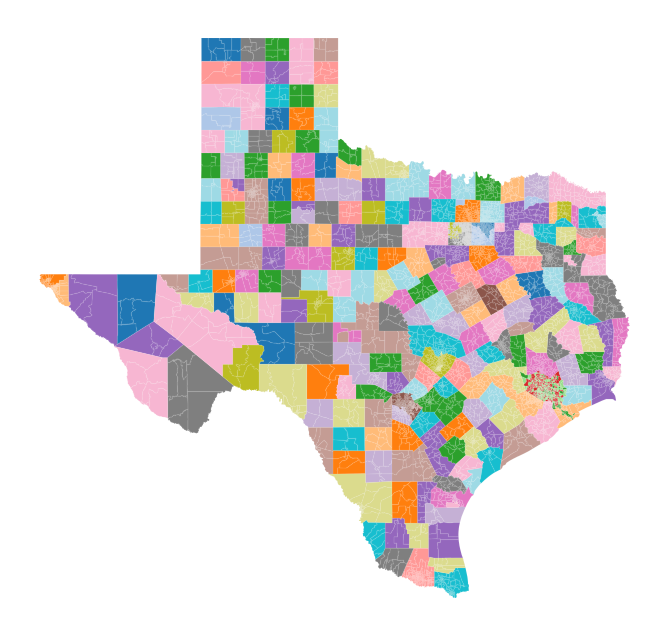

In [6]:
utility_functions.plot_district_map(df, df['CNTYVTD'].to_dict())

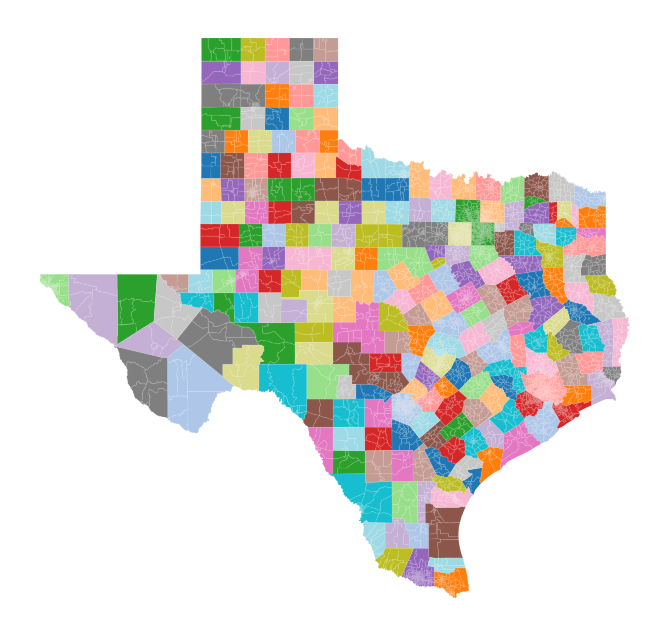

In [7]:
utility_functions.plot_district_map(df, df['CNTY_x'].to_dict())

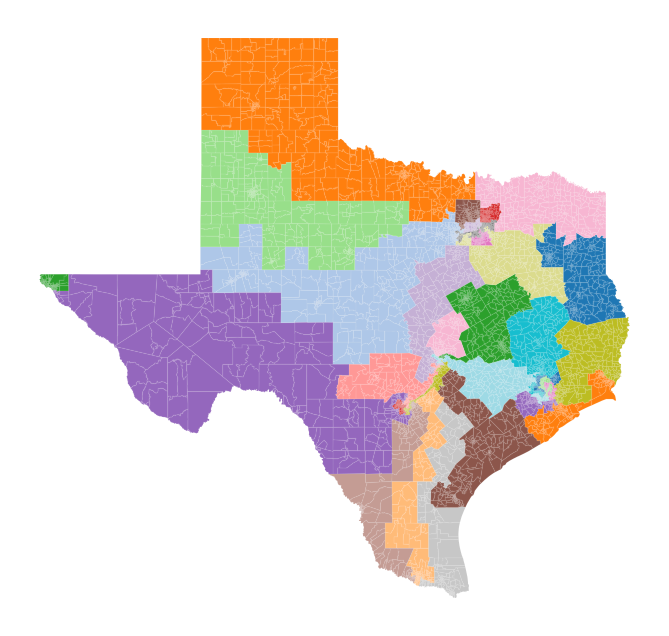

In [8]:
utility_functions.plot_district_map(df, df['CD'].to_dict())

In [9]:
df.columns.values

array(['CNTY_x', 'COLOR_x', 'VTD_x', 'CNTYVTD', 'VTDKEY_x', 'Shape_area',
       'Shape_len_', 'Unnamed_ 0', 'TOTPOP_x', 'NH_WHITE', 'NH_BLACK',
       'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'white_prop', 'black_prop',
       'hisp_prop', 'CD', 'Unnamed__1', 'RomneyR_12', 'ObamaD_12G',
       'JohnsonL_1', 'SteinG_12G', 'Write-In _', 'CruzR_12G_',
       'SadlerD_12', 'MyersL_12G', 'CollinsG_1', 'AllenD_12P',
       'HubbardD_1', 'SadlerD__1', 'YarbroughD', 'BachmannR_',
       'DavisR_12P', 'GingrichR_', 'HuntsmanR_', 'PaulR_12P_',
       'RoemerR_12', 'RomneyR__1', 'SantorumR_', 'Uncommitte',
       'AddisonR_1', 'AgrisR_12P', 'CleaverR_1', 'CruzR_12P_',
       'DewhurstR_', 'GambiniR_1', 'JamesR_12P', 'LeppertR_1',
       'PittengerR', 'SadlerD__2', 'Yarbroug_1', 'CruzR_12R_

In [10]:
# https://demographics.texas.gov/Resources/Presentations/OSD/2021/2021_01_15_LeadershipNorthTexas.pdf
    
# 254 counties in Texas: 
# "Texas Triangle - Dallas FW, San Antonio, Houson, College Station, Austin" - 75% population
# 104 lost population from 2010-2019

# Dallas -> Dallas County [County ID = 113] (portions extending into Collin (085), Denton(121), 
# Kaufman (257), & Rockwall(397) counties)
# 19% growth (+1.2M)

# Houston -> Harris County [County ID = 201]
# 19.4% growth (+1.1M)

# Austin -> Travis County [County ID = 453] (portions extending into Hays (209) & Williamson (491) counties)
# 29.8% growth  (+0.5M)


# df.CNTY_x

#### Merge 2019 Population Data

In [6]:
# ACS block group data from redistricting hub (TX has 15,811 block groups)
block_groups = gpd.read_file("Data/tx_acs5_2019_bg/tx_acs5_2019_bg.shp")

In [ ]:
maup.doctor(block_groups, df)

In [8]:
df = df.to_crs('epsg:3083')
block_groups = block_groups.to_crs('epsg:3083')

In [ ]:
with maup.progress():
    block_groups['geometry'] = maup.autorepair(block_groups)
    df['geometry'] = maup.autorepair(df)

In [ ]:
assignment = maup.assign(block_groups, df)
df['TOTPOP19'] = block_groups['TOTPOP19'].groupby(assignment).sum() 
# 2105 NAs (unmapped VTDs to blocks)
len(df[df.TOTPOP19.isna()])

In [ ]:
# Haystack Projections (block level projections - 914,231 blocks)
# P1 - ???
# P2 - ???
block_proj = gpd.read_file("Data/tx_b_proj_P1_2020tiger/tx_b_proj_P1_2020tiger.shp")
block_proj = block_proj.to_crs('epsg:3083')
block_proj['geometry'] = maup.autorepair(block_proj)

# block_proj_minor = gpd.read_file("Data/tx_b_proj_P2_2020tiger/tx_b_proj_P2_2020tiger.shp")
# block_proj_minor.head()



In [10]:
# Include area_cutoff=0 to ignore any intersections with no area,
# like boundary intersections, which we do not want to include in
# our proration.
pieces = maup.intersections(block_groups, df, area_cutoff=0)


In [ ]:
with maup.progress():
    bg2pieces = maup.assign(block_proj, pieces.reset_index())

In [13]:
# Weight by prorated population from blocks
# weights = block_proj['p20_total'].groupby(bg2pieces).sum()
# weights = maup.normalize(weights, level=0)

# Alternative: Weight by relative area
weights = pieces.geometry.area
weights = maup.normalize(weights, level=0)

with maup.progress():
    df['TOTPOP19'] = maup.prorate(pieces, block_groups['TOTPOP19'], weights=weights)

In [14]:
print(len(df[df.TOTPOP19.isna()]))
df[df.CNTY_x == 201].sum()[['TOTPOP_x', 'TOTPOP19']]

0


<ipython-input-14-e2388e6906d8>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[df.CNTY_x == 201].sum()[['TOTPOP_x', 'TOTPOP19']]


TOTPOP_x         4092459.0
TOTPOP19    4646430.540533
dtype: object

In [ ]:
# maup.doctor(block_proj, df)
# block_proj['geometry'] = maup.autorepair(block_proj)

# block_proj['geometry'] = maup.autorepair(block_proj)

# with maup.progress():
#     assignment2 = maup.assign(block_proj, df)

# df['TOTPOP20'] = (block_proj['p20_total'] 
#                  ).groupby(assignment2).sum() 

# df[df.CNTY_x == 201].sum()[['TOTPOP_x', 'TOTPOP19', 'TOTPOP20']]

In [19]:
df.to_file("Data/texas_population2020.shp")

In [15]:
df.TOTPOP_x.sum()

25145561.0

In [16]:
df.TOTPOP19.sum()

28260856.0

In [23]:
df.TOTPOP20.sum()

22208552.0

In [21]:
df2 = gpd.read_file('Data/TX_VTDs_POP2019/texas_population2019.shp')

In [22]:
df2.head()

,CNTY_x,COLOR_x,VTD_x,CNTYVTD,VTDKEY_x,Shape_area,Shape_len_,Unnamed_ 0,TOTPOP_x,NH_WHITE,...,11-2018,12-2018,13-2018,538_Dem,538_Comp_1,538_Propor,Seed3,Seed_Demo,TOTPOP19,geometry
0,1,6,0001,10001,1,5.616316e+06,15020.544212,0,3131.0,2053.0,...,0.0,0.0,227.739888,16,16,9,24,21,2499.790741,"POLYGON ((1913952.819 7522869.350, 1913963.582..."
1,1,3,0002,10002,2,2.562133e+08,94432.828741,1,3744.0,3171.0,...,0.0,0.0,294.519898,16,16,9,24,21,3344.619454,"POLYGON ((1920158.366 7516213.333, 1920244.924..."
2,1,4,0003,10003,3,7.084692e+07,55277.408984,2,1766.0,1443.0,...,0.0,0.0,214.861074,16,16,9,24,21,1852.910463,"POLYGON ((1916267.130 7522031.340, 1916402.319..."
3,1,6,0004,10004,4,2.411696e+08,91313.172999,3,2147.0,1962.0,...,0.0,0.0,178.950845,16,16,9,24,21,2528.164695,"POLYGON ((1935596.304 7524509.558, 1935666.367..."
4,1,4,0005,10005,5,1.689853e+08,86938.248879,4,476.0,454.0,...,0.0,0.0,88.589359,16,16,9,24,21,1229.818078,"POLYGON ((1936880.150 7522348.766, 1936903.174..."
